In [1]:
import numpy as np
import matplotlib.pyplot as plt

import initialconditions as ic

import main as main
import sys
sys.path.append("/home/s2250115/petsc/arch-linux-c-debug/lib")

import animators as ani

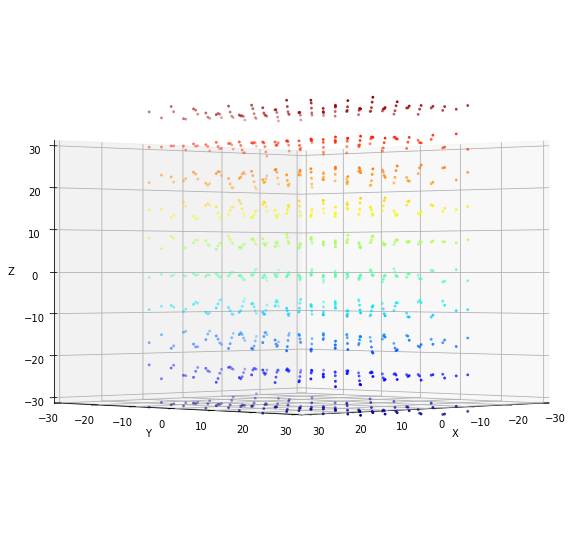

In [2]:
# Define the parameters of the system

N = 1000 # Number of seeds
B = np.array([[1, 2, 3], [2, 4, 5], [3, 5, 6]])
box = [-4, -4, 0, 4, 4, 1] # List or tuple defining domain [xmin, ymin, zmin, xmax, ymax, zmax]
per_tol = 1e-3 # Percent tolerance
per_x = False # Set the periodicity of X
per_y = False # Set the periodicity of Y
per_z = False # Set the periodicity of Z
a = 8 # Set replication parameter
tf = 10 # Final time
Ndt = 1000 # Number of timesteps

#Initialize initial condition
Z = ic.create_ss_initial(N, B, box, 'Thermal Sine') #Initial seed positions

# Plot the initial condition

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot(projection='3d')
ax.scatter(Z[:,0], Z[:,1], Z[:,2], c = Z[:,2], cmap = 'jet', edgecolor = 'none', s = 8)
ax.set_xlim([-30, 30])
ax.set_ylim([-30, 30])
ax.set_zlim([-30, 30])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev = 0, azim = 45)

plt.show()

In [3]:
main.SG_solver(box, Z, N, per_tol, tf, Ndt, per_x, per_y, per_z, a) #Solve and save the solution

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

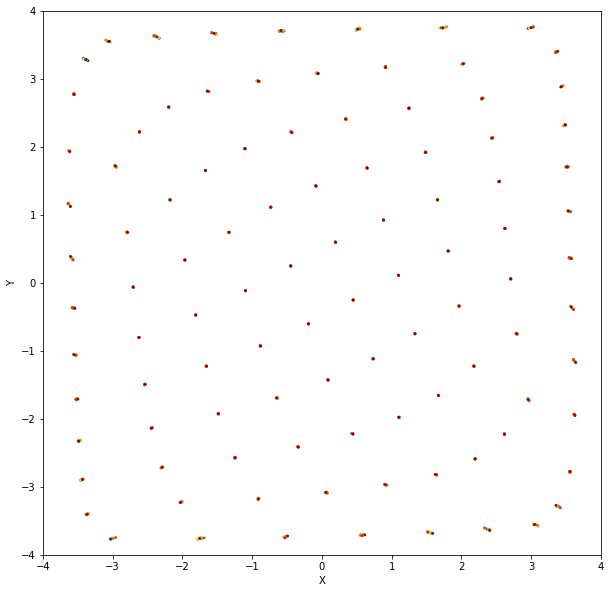

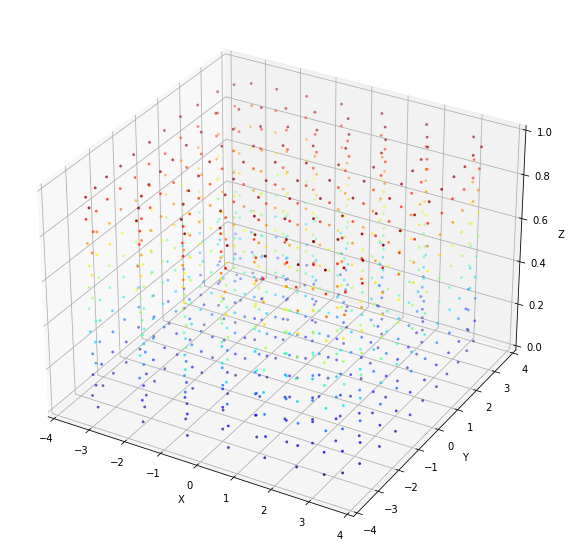

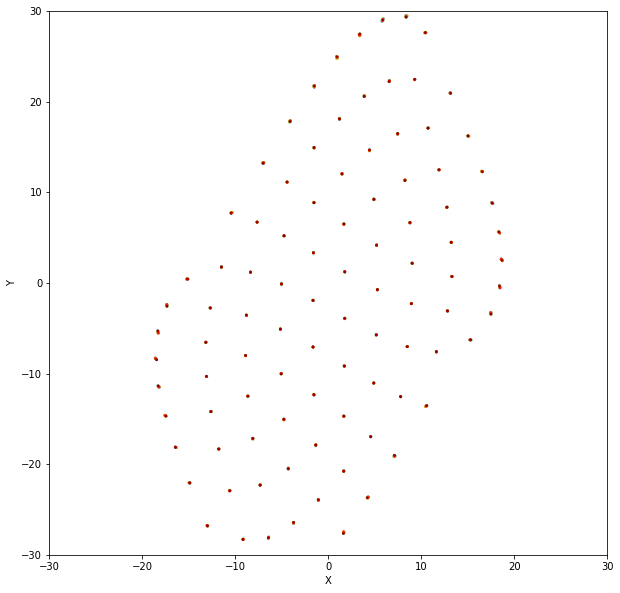

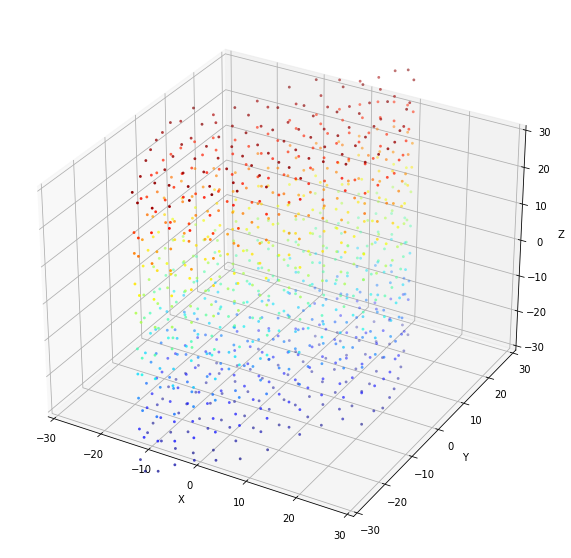

In [4]:
ani.point_animator('./SG_data.npz', 'C', '2D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.point_animator('./SG_data.npz', 'C', '3D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.point_animator('./SG_data.npz', 'Z', '2D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.point_animator('./SG_data.npz', 'Z', '3D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.cell_animator('./SG_data.npz', box) #Animate the cells

In [ ]:
from pysdot import OptimalTransport
import numpy as np
import pyvista as pv
import weightguess as wg
import optimaltransportsolver as ots

nb_diracs = 2197

masses =  64 * np.ones( nb_diracs ) / nb_diracs

domain = ots.make_domain(box, per_x, per_y, per_z, a)

psi = np.zeros(shape = (nb_diracs,))

# we have to specify that dirac masses because by default, sdot takes ones * measure( domain ) / nb_diracs
# and that's not what we want in this case
w0 = wg.rescale_weights(box, Z, psi, per_x, per_y, per_z)[0]
ot = OptimalTransport( positions = Z, domain = domain, masses = masses, weights = w0 )

# first arg of add_replication is a translation
for x in [ -a, 0, a ]:
    for y in [ -a, 0, a ]:
        if x or y:
            ot.pd.add_replication( [ x, y, 0 ] )

ot.adjust_weights()

filename = 'pb.vtk'
ot.pd.display_vtk( 'pb.vtk' )

# Mass of cells
vols=ot.pd.integrals()
print(sum(vols))

# Read the data
grid=pv.read(filename)

# create cell data that gives the cell volumes, this allows us to colour by cell volumes
cell_vols = vols[grid.cell_data['num'].astype(int)]
grid.cell_data['vols']=cell_vols

# plot the data with an automatically created plotter, for a static picture use backend='static'
plotter = pv.Plotter(window_size=[800,800], notebook = True, off_screen=False)
plotter.add_mesh(grid)

# Render the frame
plotter.show()


In [ ]:
import numpy as np

N = 2197 # Number of seeds
BP = [-4, -4, 0, 4, 4, 1]
B = np.array([[1, 2, 3], [2, 4, 5], [3, 5, 6]])

#Initialize initial condition
Z = ic.create_ss_initial(N, B, BP, 'Thermal Sine') #Initial seed positions

# Plot the initial condition

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot(projection='3d')
ax.scatter(Z[:,0], Z[:,1], Z[:,2], c = Z[:,2], cmap = 'jet', edgecolor = 'none', s = 8)
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_zlim([-50, 50])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev = 33, azim = 45)

plt.show()